In [14]:
suppressMessages(library(rwwa))

add_uw <- function(synth) {
    res <- rbind(synth$df,
                     data.frame("group" = "synth_uw", "model" = "Unweighted", "est" = synth$uw_mean,
                                "lower" = NA, "upper" = NA,
                                "l_wb" = synth$df[nrow(synth$df),"l_wb"], "u_wb" = synth$df[nrow(synth$df),"u_wb"]))
    res[res$group == "synth", c("l_wb", "u_wb")] <- NA
    res
}

In [349]:
varnm <- "tx14x"
mdl_list <- "cmip6+cordex"

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
res_obs <- read.csv(paste0("res-obs_",varnm,".csv"), row.names = "X")

res_cmip6 <- read.csv(paste0("res-cmip6_",varnm,".csv"), row.names = "X.1")
res_cmip6 <- res_cmip6[toupper(res_cmip6$include) == "Y",]

res_cordex <- read.csv(paste0("res-cordex_",varnm,".csv"), row.names = "X.1")
res_cordex <- res_cordex[toupper(res_cordex$include) == "Y",]

if (grepl("sample",mdl_list)) set.seed(as.integer(substr(mdl_list,21,nchar(mdl_list))))
res_mdl <- switch(mdl_list,
                  "cmip6-only" = res_cmip6,
                  "cordex-only" = res_cordex,
                  "cmip6+cordex" = rbind(res_cmip6, res_cordex),
                  rbind(res_cmip6, res_cordex[sample(1:nrow(res_cordex), nrow(res_cmip6)),])
                 )

In [350]:
synth_dI <- synthesis(obs_in = res_obs[,grepl("dI.abs.pi", colnames(res_obs))],
                      models_in = res_mdl[,grepl("attr_dI.abs", colnames(res_mdl))],
                      synth_type = "abs")


synth_excl_cpc <- synthesis(obs_in = res_obs[!rownames(res_obs) == "cpc",grepl("dI.abs.pi", colnames(res_obs))],
                      models_in = res_mdl[,grepl("attr_dI.abs", colnames(res_mdl))],
                      synth_type = "abs")

proj_dI <- synthesis(obs_in = NA,
                      models_in = res_mdl[,grepl("proj_dI.abs", colnames(res_mdl))],
                      synth_type = "abs")

proj_dI_withobs <- synthesis(obs_in = res_obs[!rownames(res_obs) == "cpc",grepl("dI.abs.pi", colnames(res_obs))],
                      models_in = res_mdl[,grepl("proj_dI.abs", colnames(res_mdl))],
                      synth_type = "abs")

synth_PR <- synthesis(obs_in = infer_infinite(res_obs[,grepl("PR.pi", colnames(res_obs))]),
                      models_in = infer_infinite(res_mdl[,grepl("attr_PR", colnames(res_mdl))]),
                      synth_type = "PR")

synth_PR_excl_cpc <- synthesis(obs_in = infer_infinite(res_obs[!rownames(res_obs) == "cpc",grepl("PR.pi", colnames(res_obs))]),
                      models_in = infer_infinite(res_mdl[,grepl("attr_PR", colnames(res_mdl))]),
                      synth_type = "PR")

mdl_PR <- synthesis(obs_in = NA,
                      models_in = infer_infinite(res_mdl[,grepl("attr_PR", colnames(res_mdl))]),
                      synth_type = "PR")

proj_PR <- synthesis(obs_in = NA,
                      models_in = infer_infinite(res_mdl[,grepl("proj_PR", colnames(res_mdl))]),
                      synth_type = "PR")

# write.csv(add_uw(synth_dI), paste0("synthesis/synth_dI-attr_",varnm,"_",mdl_list,"_all-obs.csv"), row.names = F)
write.csv(add_uw(synth_excl_cpc), paste0("synthesis/synth_dI-attr_",varnm,"_",mdl_list,"_era-eobs.csv"), row.names = F)

# write.csv(add_uw(synth_PR), paste0("synthesis/synth_PR-attr_",varnm,"_",mdl_list,"_all-obs.csv"), row.names = F)
write.csv(add_uw(synth_PR_excl_cpc), paste0("synthesis/synth_PR-attr_",varnm,"_",mdl_list,"_era-eobs.csv"), row.names = F)

# write.csv(proj_dI, paste0("synthesis/synth_dI-proj_",varnm,"_",mdl_list,".csv"), row.names = F)
write.csv(proj_dI$df, paste0("synthesis/synth_dI-proj_",varnm,"_",mdl_list,".csv"), row.names = F)
write.csv(proj_PR$df, paste0("synthesis/synth_PR-proj_",varnm,"_",mdl_list,".csv"), row.names = F)

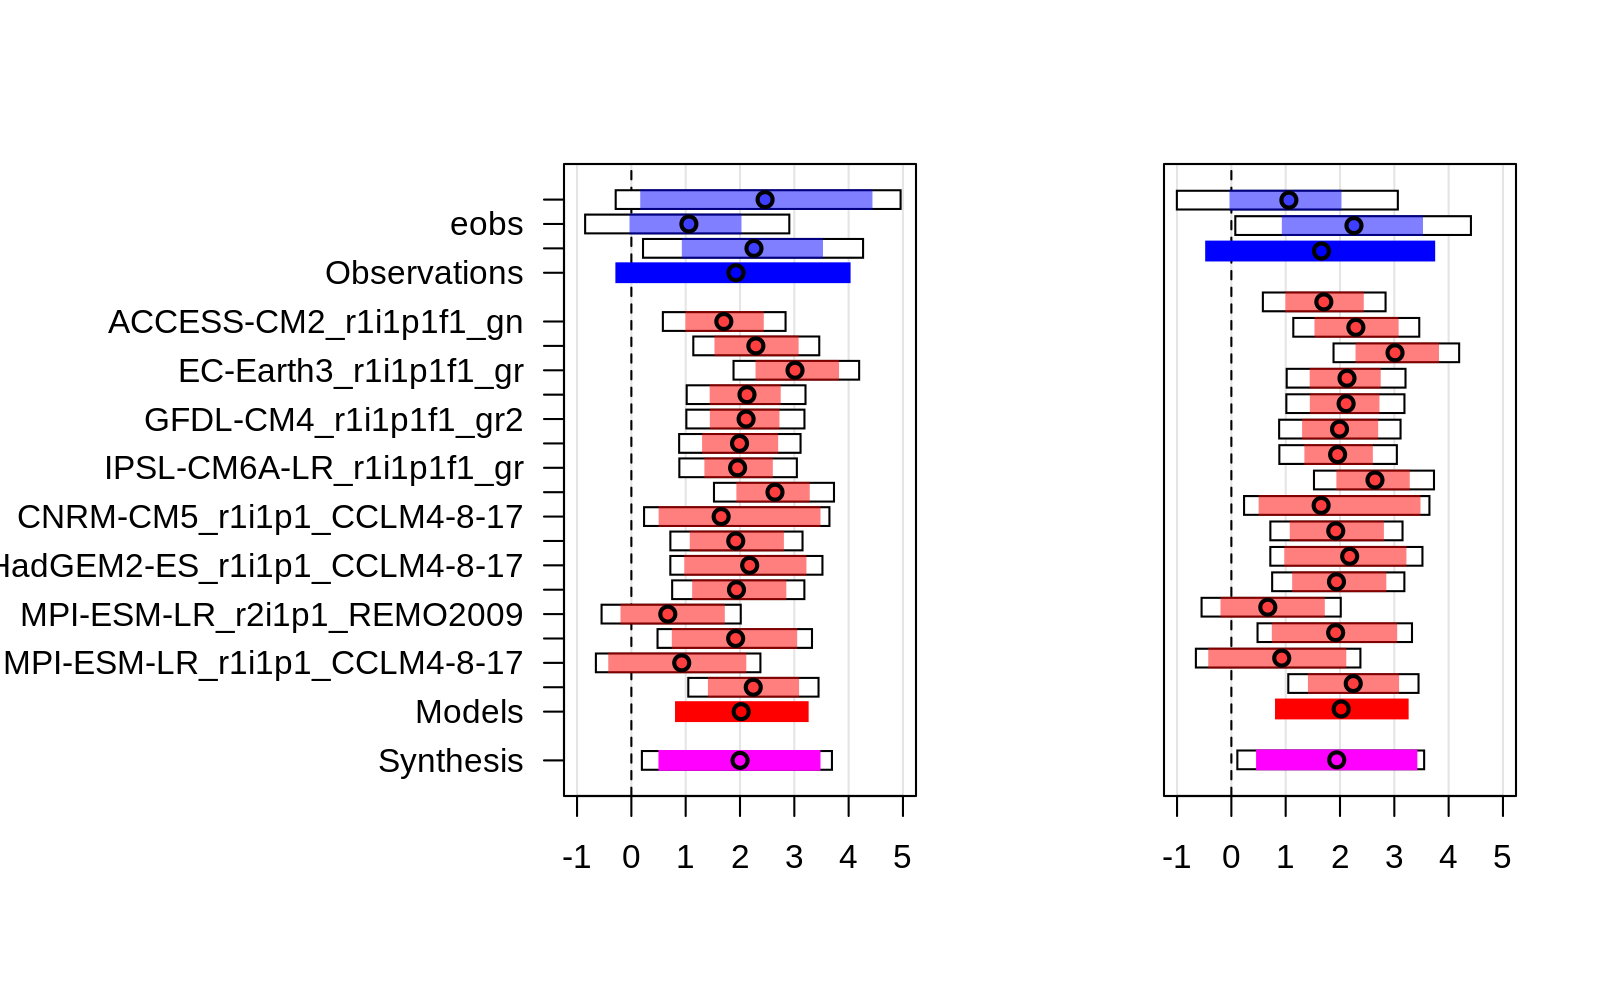

In [315]:
prep_window(c(1,2), h = 5, oma = c(0,10,0,0))

plot_synthesis(synth_dI)
plot_synthesis(synth_excl_cpc, hide_labels = T)

## Compare synthesis results

In [300]:
varnm = "tx14x"

In [301]:
synth_allobs <- sapply(c("cmip6-only", "cordex-only", "cmip6+cordex"), function(mset) {
    read.csv(paste0("synthesis/synth_dI-attr_",varnm,"_",mset,"_all-obs.csv"))
}, simplify = F)

In [302]:
synth_nocpc <- sapply(c("cmip6-only", "cordex-only", "cmip6+cordex"), function(mset) {
    read.csv(paste0("synthesis/synth_dI-attr_",varnm,"_",mset,"_era-eobs.csv"))
}, simplify = F)

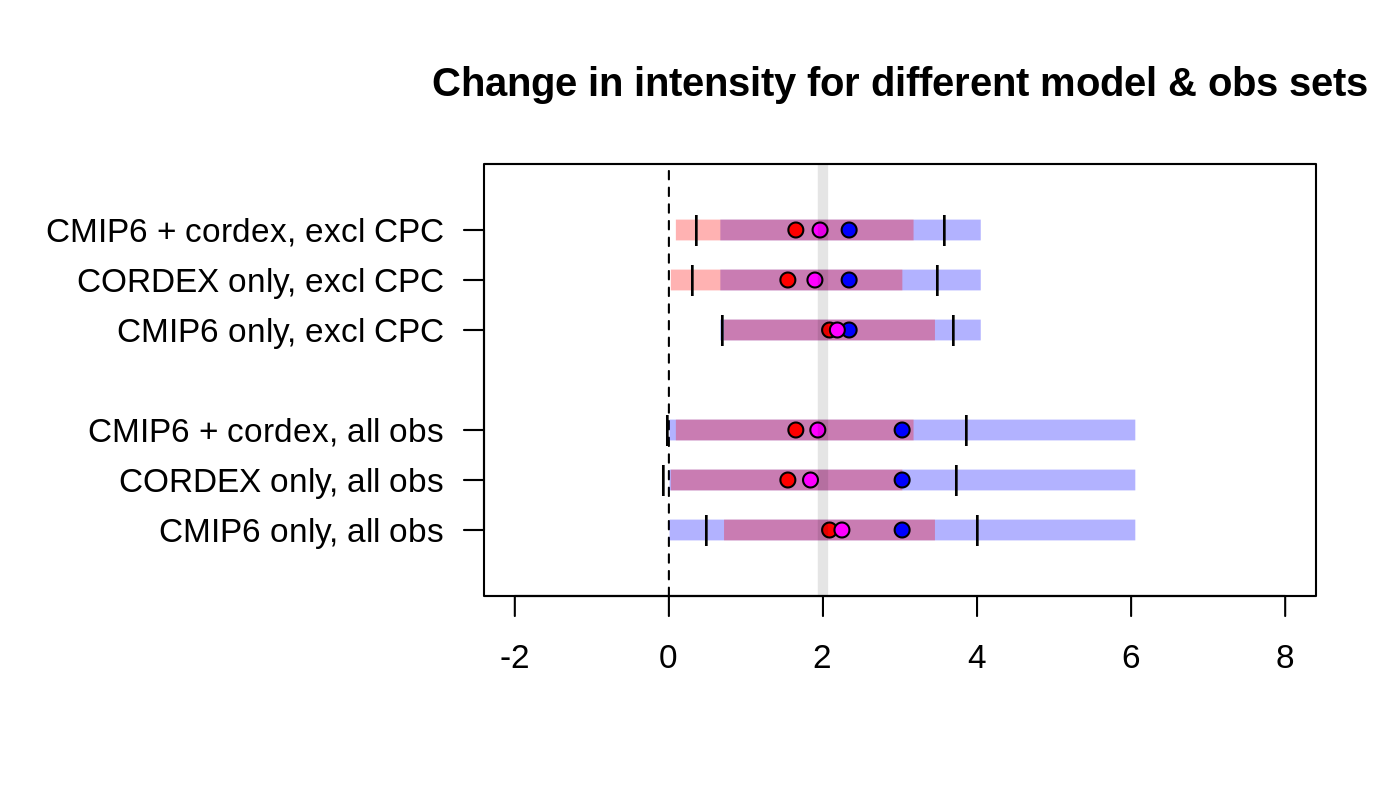

In [303]:
prep_window(oma = c(0,8,0,0), w = 7)
plot(0, type = "n", ylim = c(0,8), xlim = c(-2,8), yaxt = "n", xlab = "", ylab = "",
    main = "Change in intensity for different model & obs sets")
abline(v = 0, lty = 2)

for (i in 1:3) {
    synth_all <- synth_allobs[[i]]
    synth_all <- synth_all[grepl("synth", synth_all$group),]

    synth_ee <- synth_nocpc[[i]]
    synth_ee <- synth_ee[grepl("synth", synth_ee$group),]

    segments(y0 = i, x0 = synth_all[1,4], x1 = synth_all[1,5], col = adjustcolor("blue", alpha = 0.3), lwd = 10, lend = 1)
    segments(y0 = i, x0 = synth_all[2,4], x1 = synth_all[2,5], col = adjustcolor("red", alpha = 0.3), lwd = 10, lend = 1)
    points(synth_all[3,4:5], rep(i,2), pch = "|", lwd = 5)
    points(synth_all[1:3,3], rep(i,3), pch = 21, bg = c("blue", "red", "magenta"))

    segments(y0 = i+4, x0 = synth_ee[1,4], x1 = synth_ee[1,5], col = adjustcolor("blue", alpha = 0.3), lwd = 10, lend = 1)
    segments(y0 = i+4, x0 = synth_ee[2,4], x1 = synth_ee[2,5], col = adjustcolor("red", alpha = 0.3), lwd = 10, lend = 1)
    points(synth_ee[3,4:5], rep(i+4,2), pch = "|", lwd = 5)
    points(synth_ee[1:3,3], rep(i+4,3), pch = 21, bg = c("blue", "red", "magenta"))

}

axis(2, at = c(1:3,5:7), las = 1,
     labels = apply(merge(c("CMIP6 only", "CORDEX only", "CMIP6 + cordex"), c("all obs", "excl CPC")), 1, paste0, collapse = ", "))

abline(v = 2, col = adjustcolor("black", 0.1), lwd = 5)

# Modified synthesis 

Use all models to derive pink bar but show synthesised bars for CMIP6 and CORDEX separately (detailed figures can go in appendix)

In [152]:
split_synthesis <- function(obs, cmip6, cordex, synth_type = "abs") {
    
    synth_cmip6 <- synthesis(models_in = cmip6, synth_type = synth_type)$df
    synth_cordex <- synthesis(models_in = cordex, synth_type = synth_type)$df
    
    if (missing(obs)) {
        synth_all <- synthesis(obs_in = NA, models_in = rbind(cmip6, cordex), synth_type = synth_type)$df
        synth_summary <- rbind("Observations" = rep(NA, 5),
                               "CMIP6" = synth_cmip6[synth_cmip6$group == "model_synth",3:7],
                               "CORDEX" = synth_cordex[synth_cordex$group == "model_synth",3:7],
                               "Synthesis" = synth_all[synth_all$group == "model_synth",3:7])
    } else {
        synth_all <- synthesis(obs_in = obs, models_in = rbind(cmip6, cordex), synth_type = synth_type)$df
        synth_summary <- rbind("Observations" = synth_all[synth_all$group == "obs_synth",3:7],
                               "CMIP6" = synth_cmip6[synth_cmip6$group == "model_synth",3:7],
                               "CORDEX" = synth_cordex[synth_cordex$group == "model_synth",3:7],
                               "Synthesis" = synth_all[synth_all$group == "synth",3:7])
    }
    return(synth_summary)
}

plot_split_synth <- function(df, xlim = NA, hide_labels = F, ...) {

    if(is.na(xlim[1])) xlim <- range(pretty(unlist(df)), na.rm = T)
    
    plot(0,type = "n", xlim = xlim, ylim = c(0,5), yaxt = "n", ylab = "", xlab = "", ...)
    segments(x0 = df$lower, x1 = df$upper, y0 = 4:1, lwd = 6, col = c("blue","red","red","magenta"), lend = "butt")
    points(df$est, 4:1, pch = 21, bg = c("blue","red","red","magenta"), lwd = 2)

    if (!hide_labels) axis(2, at = 4:1, labels = rownames(df), las = 2)
}

## Straightforward synthesis with rp50

In [251]:
varnm <- "tx14x"
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# remove CPC (adds no useful information)
res_obs <- read.csv(paste0("res-obs_",varnm,".csv"), row.names = "X")
res_obs <- res_obs[c("era5","eobs"),]

res_cmip6 <- read.csv(paste0("res-cmip6_",varnm,".csv"), row.names = "X.1")
res_cmip6 <- res_cmip6[toupper(res_cmip6$include) == "Y",]

res_cordex <- read.csv(paste0("res-cordex_",varnm,".csv"), row.names = "X.1")
res_cordex <- res_cordex[toupper(res_cordex$include) == "Y",]

res_allmodels <- rbind(res_cmip6, res_cordex)

In [253]:
# synthesise change in intensity (past-present)
synth_dI.attr <- split_synthesis(obs = res_obs[,grepl("dI.abs.pi", colnames(res_obs))],
                                 cmip6 = res_cmip6[,grepl("attr_dI.abs", colnames(res_cmip6))],
                                 cordex = res_cordex[,grepl("attr_dI.abs", colnames(res_cordex))])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# synthesise probability ratio (past-present)
synth_PR.attr <- split_synthesis(obs = infer_infinite(res_obs[,grepl("PR.pi", colnames(res_obs))]),
                                 cmip6 = infer_infinite(res_cmip6[,grepl("attr_PR", colnames(res_cmip6))]),
                                 cordex = infer_infinite(res_cordex[,grepl("attr_PR", colnames(res_cordex))]),
                                synth_type = "PR")

# obs uncertainty is still too high - just use results from models
synth_PR.attr_modelsonly <- synthesis(obs_in = NA, 
                                      models_in = infer_infinite(rbind(res_cmip6[,grepl("attr_PR", colnames(res_cmip6))],
                                                                       res_cordex[,grepl("attr_PR", colnames(res_cordex))])), 
                                      synth_type = "PR")$df

df_PR.attr_modelsonly <- rbind("Observations" = rep(NA,5),
                               synth_PR.attr[c("CMIP6", "CORDEX"),],
                               "Models" = synth_PR.attr_modelsonly[nrow(synth_PR.attr_modelsonly),-(1:2)])

# pick up whichever one needs to be plotted
PR_to_plot = switch(varnm, "tx14x" = df_PR.attr_modelsonly, "tn14x" = synth_PR.attr)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# synthesise change in intensity (present-future)
synth_dI.proj <- split_synthesis(cmip6 = res_cmip6[,grepl("proj_dI.abs", colnames(res_cmip6))],
                                 cordex = res_cordex[,grepl("proj_dI.abs", colnames(res_cordex))])

synth_PR.proj <- split_synthesis(cmip6 = infer_infinite(res_cmip6[,grepl("proj_PR", colnames(res_cmip6))]),
                                 cordex = infer_infinite(res_cordex[,grepl("proj_PR", colnames(res_cordex))]),
                                synth_type = "PR")

In [ ]:
# make a nice table of the results
sapply(list("dI_past" = synth_dI.attr, "PR_past" = PR_to_plot, "dI_fut" = synth_dI.proj, "PR_fut" = synth_PR.proj), function(df) {
    apply(signif(df[,1:3], 2), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")"))
})

In [249]:
# and make the plots
xlim_dI <- list("tx14x" = c(0,4), "tn14x" = c(-1,4))[[varnm]]
xlim_PR <- list("tx14x" = c(0.1,1e5), "tn14x" = c(0.1,1e7))[[varnm]]

png(paste0("fig/synth-modified_attr_",varnm,".png"), h = 360, w = 360*2); {
    prep_window(c(1,2), oma = c(0,6,0,0), mar = c(4,0.5,2,0.5))

    plot_split_synth(synth_dI.attr, main = "(a) Change in intensity", xlim = xlim_dI)
    abline(v = 0, lty = 2)
    abline(v = -1:5, col = adjustcolor("black", 0.1))
    mtext(side = 1, "Temperature change (degC)", line = 2.5)

    plot_split_synth(PR_to_plot, hide_labels = T, main = "(b) Probability ratio", log = "x", xlim = xlim_PR)
    abline(v = 1, lty = 2)
    abline(v = 10^(-1:7), col = adjustcolor("black", 0.1))
    mtext(side = 1, "Probability ratio", line = 2.5)
}; dev.off()

png(paste0("fig/synth-modified_proj_",varnm,".png"), h = 360, w = 360*2); {
    prep_window(c(1,2), oma = c(0,6,0,0), mar = c(4,0.5,2,0.5))

    plot_split_synth(synth_dI.proj, main = "(a) Change in intensity", xlim = xlim_dI)
    abline(v = 0, lty = 2)
    abline(v = -1:5, col = adjustcolor("black", 0.1))
    mtext(side = 1, "Temperature change (degC)", line = 2.5)
    
    plot_split_synth(synth_PR.proj, hide_labels = T, main = "(b) Probability ratio", log = "x", xlim = xlim_PR)
    abline(v = 1, lty = 2)
    abline(v = 10^(-1:7), col = adjustcolor("black", 0.1))
    mtext(side = 1, "Probability ratio", line = 2.5)
}; dev.off()

png 
  2

png 
  2

In [250]:
# and save all the results for posterity
for (stype in c("dI.abs", "PR")) {
    
    synth_type = switch(stype, "dI.abs" = "abs", "PR" = "PR")

    obs = res_obs[,grepl(paste0(stype,".pi"), colnames(res_obs))]
    
    for (period in c("attr", "proj")) {

        # clean up the data
        cmip6 = res_cmip6[,grepl(paste0(period,"_",stype), colnames(res_cmip6))]
        cordex = res_cordex[,grepl(paste0(period,"_",stype), colnames(res_cordex))]

        if(stype == "PR") {
            obs <- infer_infinite(obs)
            cmip6 <- infer_infinite(cmip6)
            cordex <- infer_infinite(cordex)
        }
        if (period == "proj") obs <- NA

        # cmip6 models only
        write.csv(synthesis(obs_in = NA, models_in = cmip6, synth_type = synth_type)$df,
                  paste0("synthesis/synth_",substr(stype,1,2),"-",period,"_",varnm,"_cmip6.csv"), row.names = F)

        # cordex models only
        write.csv(synthesis(obs_in = NA, models_in = cordex, synth_type = synth_type)$df,
                  paste0("synthesis/synth_",substr(stype,1,2),"-",period,"_",varnm,"_cordex.csv"), row.names = F)

        # full synthesis
        write.csv(synthesis(obs_in = obs, models_in = rbind(cmip6, cordex), synth_type = synth_type)$df,
                 paste0("synthesis/synth_",substr(stype,1,2),"-",period,"_",varnm,"_full-synthesis.csv"), row.names = F)
    }
}

## Faffing around with infinite values for rp100

In [19]:
varnm <- "tx14x"
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
res_obs <- read.csv(paste0("res-obs_",varnm,".csv"), row.names = "X")[c("era5","eobs"),]

res_cmip6 <- read.csv(paste0("res-cmip6_",varnm,".csv"), row.names = "X.1")
res_cmip6 <- res_cmip6[toupper(res_cmip6$include) == "Y",]

res_cordex <- read.csv(paste0("res-cordex_",varnm,".csv"), row.names = "X.1")
res_cordex <- res_cordex[toupper(res_cordex$include) == "Y",]

res_allmodels <- rbind(res_cmip6, res_cordex)

In [20]:
synth_cmip6 <- synthesis(models_in = res_cmip6[,grepl("attr_dI.abs", colnames(res_cmip6))], synth_type = "abs")$df
synth_cordex <- synthesis(models_in = res_cordex[,grepl("attr_dI.abs", colnames(res_cordex))])$df

synth_all <- synthesis(obs_in = res_obs[,grepl("dI.abs.pi", colnames(res_obs))],
                      models_in = res_allmodels[,grepl("attr_dI.abs", colnames(res_allmodels))])$df

synth_summary <- rbind("Observations" = synth_all[synth_all$group == "obs_synth",3:7],
                       "CMIP6" = synth_cmip6[synth_cmip6$group == "model_synth",3:7],
                       "CORDEX" = synth_cordex[synth_cordex$group == "model_synth",3:7],
                       "Synthesis" = synth_all[synth_all$group == "synth",3:7])

# for PR, filter out only those models with a finite best estimate of the PR (tx14x: still 53 CORDEX models, 8 CMIP6, one obs dataset)
obs_finite <- res_obs[is.finite(res_obs$PR.pi_est),grepl("PR.pi", colnames(res_obs))]
cordex_finite <- res_cordex[is.finite(res_cordex$attr_PR_est),grepl("attr_PR", colnames(res_cordex))]
cmip6_finite <- res_cmip6[is.finite(res_cmip6$attr_PR_est),grepl("attr_PR", colnames(res_cmip6))]

synth_finite_cordex <- synthesis(models_in = infer_infinite(cordex_finite), synth_type = "PR")$df
synth_finite_cmip6 <- synthesis(models_in = infer_infinite(cmip6_finite), synth_type = "PR")$df
synth_finite_all <- synthesis(obs_in = infer_infinite(obs_finite), models_in = infer_infinite(cordex_finite), synth_type = "PR")$df

synth_finite <- rbind("Observations" = synth_finite_all[synth_finite_all$group == "obs_synth",3:7],
                       "CMIP6" = synth_finite_cmip6[synth_finite_cmip6$group == "model_synth",3:7],
                       "CORDEX" = synth_finite_cordex[synth_finite_cordex$group == "model_synth",3:7],
                       "Synthesis" = synth_finite_all[synth_finite_all$group == "synth",3:7])

In [21]:
synth_proj_cmip6 <- synthesis(models_in = res_cmip6[,grepl("proj_dI.abs", colnames(res_cmip6))], synth_type = "abs")$df
synth_proj_cordex <- synthesis(models_in = res_cordex[,grepl("proj_dI.abs", colnames(res_cordex))])$df

synth_proj_all <- synthesis(models_in = res_allmodels[,grepl("proj_dI.abs", colnames(res_allmodels))])$df

proj_summary <- rbind("Observations" = rep(NA, 5),
                      "CMIP6" = synth_proj_cmip6[synth_proj_cmip6$group == "model_synth",3:7],
                       "CORDEX" = synth_proj_cordex[synth_proj_cordex$group == "model_synth",3:7],
                       "Synthesis" = synth_proj_all[synth_proj_all$group == "model_synth",3:7])

# for PR, filter out only those models with a finite best estimate of the PR (tx14x: still 53 CORDEX models, 8 CMIP6, one obs dataset)
cordex_finiteproj <- res_cordex[is.finite(res_cordex$proj_PR_est),grepl("proj_PR", colnames(res_cordex))]
cmip6_finiteproj <- res_cmip6[is.finite(res_cmip6$proj_PR_est),grepl("proj_PR", colnames(res_cmip6))]

proj_finite_cordex <- synthesis(models_in = cordex_finiteproj, synth_type = "PR")$df
proj_finite_cmip6 <- synthesis(models_in = infer_infinite(cmip6_finiteproj), synth_type = "PR")$df
proj_finite_all <- synthesis(obs_in = NA, models_in = infer_infinite(rbind(cmip6_finiteproj, cordex_finiteproj)), synth_type = "PR")$df

proj_finite <- rbind("Observations" = rep(NA, 5),
                     "CMIP6" = proj_finite_cmip6[proj_finite_cmip6$group == "model_synth",3:7],
                     "CORDEX" = proj_finite_cordex[proj_finite_cordex$group == "model_synth",3:7],
                     "Synthesis" = proj_finite_all[proj_finite_all$group == "model_synth",3:7])

In [396]:
xlim_pr <- switch(varnm, "tx14x" = c(0.1, 10e5), "tn14x" = c(0.1, 10e4))
xlim_di <- switch(varnm, "tx14x" = c(0,5), "tn14x" = c(-1,4))

png(paste0("fig/synth-plots_",varnm,"_past-present_R.png"), h = 360, w = 360*2); {
    prep_window(c(1,2), oma = c(0,6,0,0), w = 4, mar = c(4,0.5,3,0.5))
    
    plot(0,type = "n", xlim = xlim_di, ylim = c(0,5), yaxt = "n", ylab = "", xlab = "Change in temperature (°C)", main = "(a) Change in intensity")
    abline(v = 1:5, col = adjustcolor("black", 0.1))
    abline(v = 0, lty = 2)
    segments(x0 = synth_summary$lower, x1 = synth_summary$upper, y0 = 4:1, lwd = 6, col = c("blue","red","red","magenta"), lend = "butt")
    points(synth_summary$est, 4:1, pch = 21, bg = c("blue","red","red","magenta"), lwd = 2)
    axis(2, at = 4:1, labels = rownames(synth_summary), las = 2)
    
    plot(0,type = "n", xlim = xlim_pr, ylim = c(0,5), yaxt = "n", ylab = "", xlab = "Probability ratio", log = "x", main = "(b) Change in likelihood")
    abline(v = 10^(1:5), col = adjustcolor("black", 0.1))
    abline(v = 1, lty = 2)
    segments(x0 = synth_finite$lower, x1 = synth_finite$upper, y0 = 4:1, lwd = 6, col = c("blue","red","red","magenta"), lend = "butt")
    points(synth_finite$est, 4:1, pch = 21, bg = c("blue","red","red","magenta"), lwd = 2)
}; dev.off()

png(paste0("fig/synth-plots_",varnm,"_present-future_R.png"), h = 360, w = 360*2); {
    prep_window(c(1,2), oma = c(0,6,0,0), w = 4, mar = c(4,0.5,3,0.5))
    
    plot(0,type = "n", xlim = xlim_di, ylim = c(0,4), yaxt = "n", ylab = "", xlab = "Change in temperature (°C)", main = "(a) Change in intensity")
    abline(v = 1:3, col = adjustcolor("black", 0.1))
    abline(v = 0, lty = 2)
    segments(x0 = proj_summary$lower, x1 = proj_summary$upper, y0 = 4:1, lwd = 6, col = c("blue","red","red","magenta"), lend = "butt")
    points(proj_summary$est, 4:1, pch = 21, bg = c("blue","red","red","magenta"), lwd = 2)
    axis(2, at = 3:1, labels = rownames(proj_summary)[-1], las = 2)
    
    plot(0, type = "n", xlim = xlim_pr, ylim = c(0,4), yaxt = "n", ylab = "", xlab = "Probability ratio", log = "x", main = "(b) Change in likelihood")
    abline(v = 10^(1:5), col = adjustcolor("black", 0.1))
    abline(v = 1, lty = 2)
    segments(x0 = proj_finite$lower, x1 = proj_finite$upper, y0 = 4:1, lwd = 6, col = c("blue","red","red","magenta"), lend = "butt")
    points(proj_finite$est, 4:1, pch = 21, bg = c("blue","red","red","magenta"), lwd = 2)
}; dev.off()

png 
  2

png 
  2

In [397]:
data.frame("dI_past" = apply(signif(synth_summary[,1:3], 2), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")")),
           "PR_past" = apply(signif(synth_finite[,1:3], 2), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")")),
           "dI_fut" = apply(signif(proj_summary[,1:3], 2), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")")),
           "PR_fut" = apply(signif(proj_finite[,1:3], 2), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")")))

,dI_past,PR_past,dI_fut,PR_fut
,<chr>,<chr>,<chr>,<chr>
Observations,"1.7 (-0.29, 3.6)","14 (0.31, 2800)","NA (NA, NA)","NA (NA, NA)"
CMIP6,"2.2 (1.4, 3)","34 (11, 1900)","2 (1.5, 2.6)","4 (3.6, 4.6)"
CORDEX,"1.8 (0.66, 2.9)","12 (2.5, 860)","1.6 (0.84, 2.3)","3.7 (2.6, 5.1)"
Synthesis,"1.8 (0.46, 3.2)","12 (1.1, 1300)","1.7 (0.87, 2.5)","3.8 (2.8, 5.1)"


In [ ]:
s